/tmp/ipykernel_27101/850853222.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(teams))


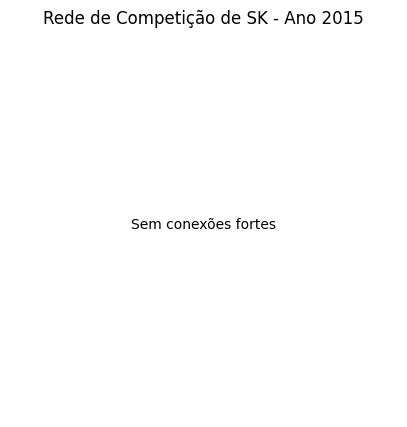

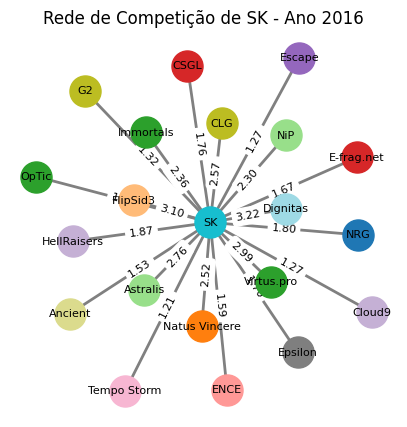

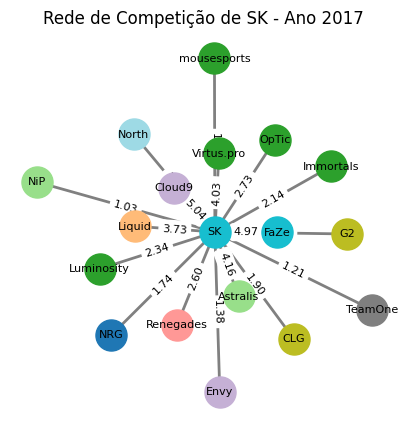

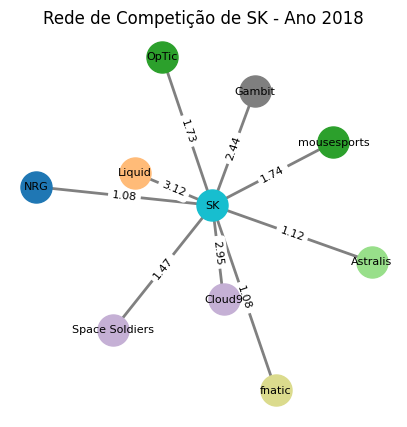

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

team_to_analyze = 'SK'  # Nome da equipe
df = pd.read_csv('../../db/results.csv')

# Conversões necessárias
df['result_1'] = pd.to_numeric(df['result_1'], errors='coerce')
df['result_2'] = pd.to_numeric(df['result_2'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Filtragem por equipe
df_filtered = df[(df['team_1'] == team_to_analyze) | (df['team_2'] == team_to_analyze)]

minRivalry = 1  # Limiar de rivalidade

# Agrupamento por ano e construção do grafo
graphs_by_year = {}
for year, group in df_filtered.groupby('year'):
    G = nx.Graph()
    for index, row in group.iterrows():
        # Cálculo do peso
        score_diff = abs(row['result_1'] - row['result_2'])
        weight = 1 if score_diff == 0 else 1 / score_diff
        if row['map_winner'] == '1':
            weight += 1
        elif row['map_winner'] == '2':
            weight += 1
        
        opponent = row['team_2'] if row['team_1'] == team_to_analyze else row['team_1']
        if G.has_edge(team_to_analyze, opponent):
            G.edges[team_to_analyze, opponent]['weight'] += weight
        else:
            G.add_edge(team_to_analyze, opponent, weight=weight)

    # Filtragem por minRivalry
    H = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > minRivalry])
    graphs_by_year[year] = H

# Gerar cores para cada equipe
teams = set(df['team_1']).union(set(df['team_2']))
colors = plt.cm.get_cmap('tab20', len(teams))
team_colors = {team: colors(i) for i, team in enumerate(teams)}

# Verificar se há dados suficientes para criar subplots
if not graphs_by_year:
    print(f"Não foram encontradas partidas para a equipe {team_to_analyze} em nenhum ano.")
else:
    for year, H in graphs_by_year.items():
        plt.figure(figsize=(5, 5))
        pos = nx.spring_layout(H, seed=42)
        if H.edges:
            for u, v, d in H.edges(data=True):
                nx.draw_networkx_edges(H, pos, edgelist=[(u, v)], width=2, edge_color='gray')

            for node in H.nodes():
                nx.draw_networkx_nodes(H, pos, nodelist=[node], node_size=500, node_color=[team_colors[node]])
            
            nx.draw_networkx_labels(H, pos, font_size=8)

            edge_weights = nx.get_edge_attributes(H, 'weight')
            formatted_edge_weights = {e: f"{w:.2f}" for e, w in edge_weights.items()}
            nx.draw_networkx_edge_labels(H, pos, edge_labels=formatted_edge_weights, font_size=8)
        else:
            plt.text(0.5, 0.5, 'Sem conexões fortes', horizontalalignment='center', verticalalignment='center')
        
        plt.title(f'Rede de Competição de {team_to_analyze} - Ano {year}', fontsize=12)
        plt.axis('off')
        plt.show()


/tmp/ipykernel_27101/2255003956.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(teams))


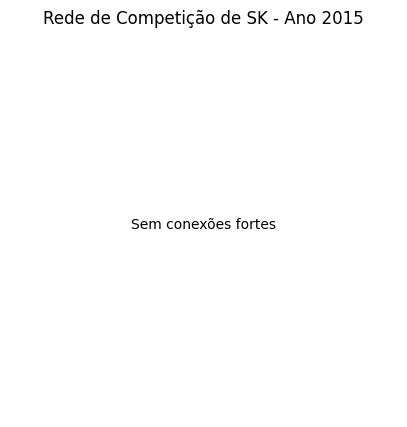

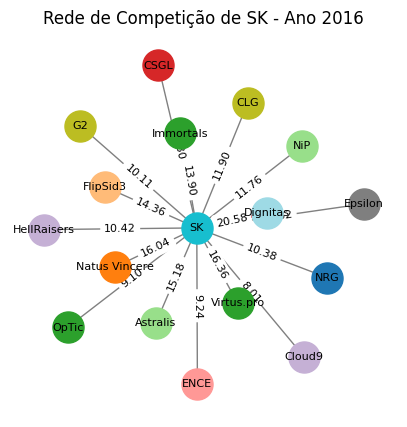

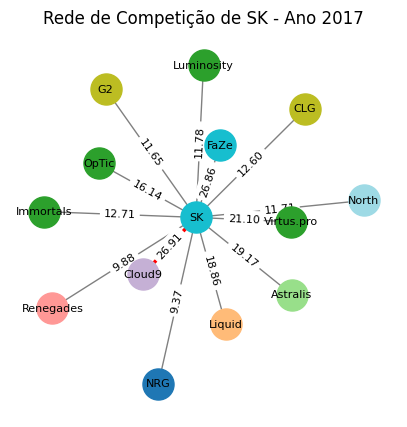

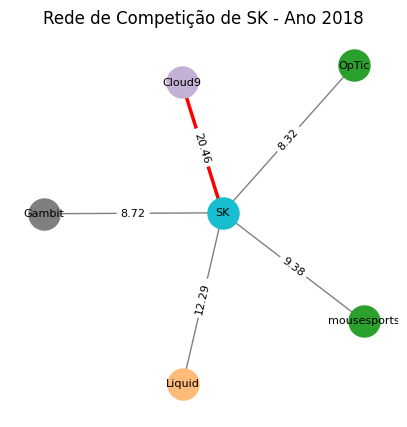

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

team_to_analyze = 'SK'
df = pd.read_csv('../../db/results.csv')

df['result_1'] = pd.to_numeric(df['result_1'], errors='coerce')
df['result_2'] = pd.to_numeric(df['result_2'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

df_filtered = df[(df['team_1'] == team_to_analyze) | (df['team_2'] == team_to_analyze)]

minRivalry = 8

graphs_by_year = {}
for year, group in df_filtered.groupby('year'):
    G = nx.Graph()
    for index, row in group.iterrows():
        score_diff = abs(row['result_1'] - row['result_2'])
        weight = 1 + (1 / (1 + score_diff))
        if row['map_winner'] in ['1', '2']:
            weight += 0.5
        
        opponent = row['team_2'] if row['team_1'] == team_to_analyze else row['team_1']
        if G.has_edge(team_to_analyze, opponent):
            G.edges[team_to_analyze, opponent]['weight'] += weight
        else:
            G.add_edge(team_to_analyze, opponent, weight=weight)

    H = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > minRivalry])
    graphs_by_year[year] = H

teams = set(df['team_1']).union(set(df['team_2']))
colors = plt.cm.get_cmap('tab20', len(teams))
team_colors = {team: colors(i) for i, team in enumerate(teams)}

if not graphs_by_year:
    print(f"Não foram encontradas partidas para a equipe {team_to_analyze} em nenhum ano.")
else:
    for year, H in graphs_by_year.items():
        plt.figure(figsize=(5, 5))
        pos = nx.spring_layout(H, seed=42)

        if H.edges:
            max_weight_edge = max(H.edges(data=True), key=lambda e: e[2]['weight'])

            # Desenhar as arestas normais
            normal_edges = [(u, v) for u, v, d in H.edges(data=True) if (u, v) != (max_weight_edge[0], max_weight_edge[1])]
            nx.draw_networkx_edges(H, pos, edgelist=normal_edges, edge_color='gray')

            # Desenhar a aresta de maior peso em vermelho e em negrito
            nx.draw_networkx_edges(H, pos, edgelist=[(max_weight_edge[0], max_weight_edge[1])], width=2.5, edge_color='red')

            for node in H.nodes():
                nx.draw_networkx_nodes(H, pos, nodelist=[node], node_size=500, node_color=[team_colors[node]])
            
            nx.draw_networkx_labels(H, pos, font_size=8)
            edge_weights = nx.get_edge_attributes(H, 'weight')
            formatted_edge_weights = {e: f"{w:.2f}" for e, w in edge_weights.items()}
            nx.draw_networkx_edge_labels(H, pos, edge_labels=formatted_edge_weights, font_size=8)
        else:
            plt.text(0.5, 0.5, 'Sem conexões fortes', horizontalalignment='center', verticalalignment='center')
        
        plt.title(f'Rede de Competição de {team_to_analyze} - Ano {year}', fontsize=12)
        plt.axis('off')
        plt.show()


/tmp/ipykernel_27101/3161321259.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(teams))


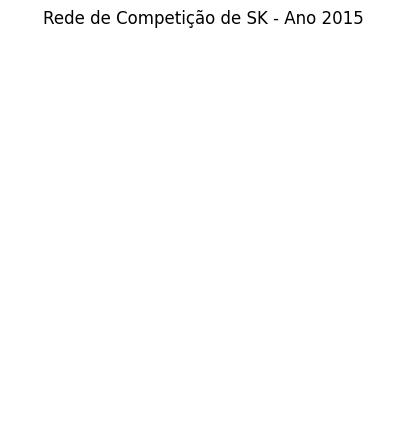

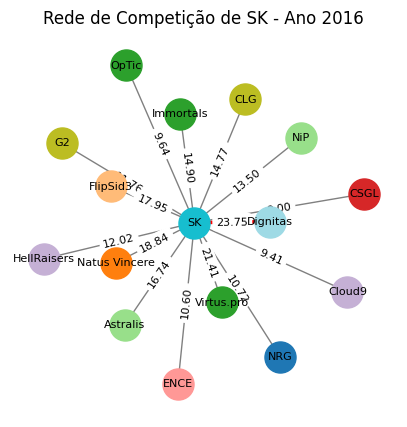

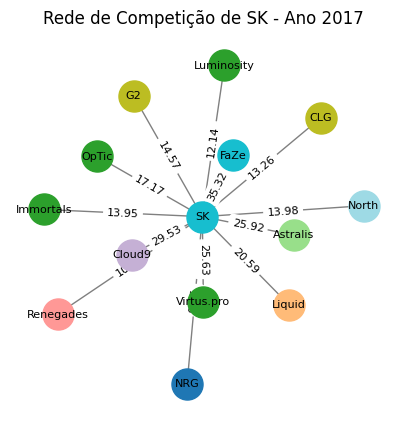

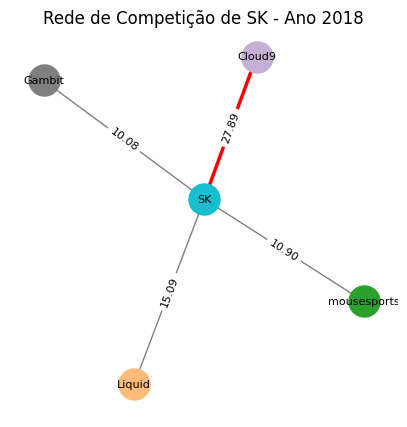

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

team_to_analyze = 'SK'  # Substitua pelo nome da equipe desejada
df = pd.read_csv('../../db/results.csv')

# Conversões necessárias
df['result_1'] = pd.to_numeric(df['result_1'], errors='coerce')
df['result_2'] = pd.to_numeric(df['result_2'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Supondo que você tem colunas 'rank_team_1' e 'rank_team_2' para o ranking das equipes
df['rank_1'] = pd.to_numeric(df['rank_1'], errors='coerce')
df['rank_2'] = pd.to_numeric(df['rank_2'], errors='coerce')

df_filtered = df[(df['team_1'] == team_to_analyze) | (df['team_2'] == team_to_analyze)]

minRivalry = 9 # Limiar de rivalidade

graphs_by_year = {}
for year, group in df_filtered.groupby('year'):
    G = nx.Graph()
    for index, row in group.iterrows():
        score_diff = abs(row['result_1'] - row['result_2'])
        rank_diff = abs(row['rank_1'] - row['rank_2'])
        weight = 1 + (1 / (1 + score_diff)) + (1 / (1 + rank_diff))
        if row['map_winner'] in ['1', '2']:
            weight += 0.5
        
        opponent = row['team_2'] if row['team_1'] == team_to_analyze else row['team_1']
        if G.has_edge(team_to_analyze, opponent):
            G.edges[team_to_analyze, opponent]['weight'] += weight
        else:
            G.add_edge(team_to_analyze, opponent, weight=weight)

    H = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > minRivalry])
    graphs_by_year[year] = H

teams = set(df['team_1']).union(set(df['team_2']))
colors = plt.cm.get_cmap('tab20', len(teams))
team_colors = {team: colors(i) for i, team in enumerate(teams)}

if not graphs_by_year:
    print(f"Não foram encontradas partidas para a equipe {team_to_analyze} em nenhum ano.")
else:
    for year, H in graphs_by_year.items():
        plt.figure(figsize=(5, 5))
        pos = nx.spring_layout(H, seed=42)

        max_weight_edge = max(H.edges(data=True), key=lambda e: e[2]['weight'], default=None)
        normal_edges = [(u, v) for u, v, d in H.edges(data=True) if (u, v) != (max_weight_edge[0], max_weight_edge[1])]

        nx.draw_networkx_edges(H, pos, edgelist=normal_edges, edge_color='gray')
        if max_weight_edge:
            nx.draw_networkx_edges(H, pos, edgelist=[(max_weight_edge[0], max_weight_edge[1])], width=2.5, edge_color='red')

        for node in H.nodes():
            nx.draw_networkx_nodes(H, pos, nodelist=[node], node_size=500, node_color=[team_colors[node]])
        
        nx.draw_networkx_labels(H, pos, font_size=8)
        edge_weights = nx.get_edge_attributes(H, 'weight')
        formatted_edge_weights = {e: f"{w:.2f}" for e, w in edge_weights.items()}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=formatted_edge_weights, font_size=8)

        plt.title(f'Rede de Competição de {team_to_analyze} - Ano {year}', fontsize=12)
        plt.axis('off')
        plt.show()
